In [9]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

import importlib
import utils.gmm
import utils.metrics
import utils.priors
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
importlib.reload(utils.priors)
from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture


In [10]:
# Set device
#device = 'cuda'
device = 'cpu'

# Parameters
n_features = 2
n_components = 4
random_state = 42
max_iter = 1000

# Seed for reproducibility
np.random.seed(random_state)
torch.manual_seed(random_state)

# Generate synthetic data
n_samples = [1000, 1000, 1000, 1000]
centers = [np.array([0, 0]), np.array([-0, 2]), np.array([2, -0]), np.array([2, 2])]
covs = [
    np.array([[0.0, -0.5], [1.5, 0.5]]),
    0.7 * np.eye(2),
    0.5 * np.eye(2),
    np.array([[0.0, 0.2], [0.4, 1.7]])
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    if cov.shape == (2, 2):
        samples = np.dot(np.random.randn(n, 2), cov) + center
    else:
        samples = np.random.multivariate_normal(center, cov, n)
    components.append(samples)

X = np.vstack(components)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# Initialize and fit the GMM
gmm = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=max_iter,
    init_params='kmeans',
    random_state=random_state,
    device=device,
    verbose=True,
    verbose_interval=1
)
gmm.fit(X_tensor)

# Get predictions
y_pred = gmm.predict(X_tensor)

# Compute per-sample log-likelihoods
log_probs = gmm.score_samples(X_tensor)

# Get probabilities for each sample for each component
probs = gmm.predict_proba(X_tensor)
probs = probs.detach()

# Generate new samples
n_samples_to_generate = 4000
gmm_samples, gmm_labels = gmm.sample(n_samples_to_generate)
gmm_samples = gmm_samples.detach().cpu().numpy()
gmm_labels = gmm_labels.detach().cpu().numpy()

# Compute probabilities for each generated sample
generated_probs = gmm.predict_proba(torch.tensor(gmm_samples, dtype=torch.float32).to(device))
generated_probs = generated_probs.detach().cpu().numpy()

print('Mean per-sample log-likelihood:', gmm.score(X_tensor))
print('Std per-sample log-likelihood:', torch.std(log_probs).item())
print('Lower bound:', gmm.lower_bound_)
print('Number of iterations:', gmm.n_iter_)
print('Sum of log-likelihoods:', torch.sum(log_probs).item())

Iteration 0, lower bound: -3.4848432540893555
Iteration 1, lower bound: -3.1867058277130127
Iteration 2, lower bound: -3.116245746612549
Iteration 3, lower bound: -3.006471872329712
Iteration 4, lower bound: -2.8628690242767334
Iteration 5, lower bound: -2.7806856632232666
Iteration 6, lower bound: -2.7646265029907227
Iteration 7, lower bound: -2.7604730129241943
Iteration 8, lower bound: -2.758042812347412
Iteration 9, lower bound: -2.7560863494873047
Iteration 10, lower bound: -2.7544937133789062
Iteration 11, lower bound: -2.7532386779785156
Iteration 12, lower bound: -2.752279281616211
Iteration 13, lower bound: -2.7515621185302734
Iteration 14, lower bound: -2.7510335445404053
Iteration 15, lower bound: -2.7506484985351562
Iteration 16, lower bound: -2.7503700256347656
Converged at iteration 17 with lower bound -2.750169515609741
Mean per-sample log-likelihood: -2.750025749206543
Std per-sample log-likelihood: 1.2107199430465698
Lower bound: -2.750169515609741
Number of iterations

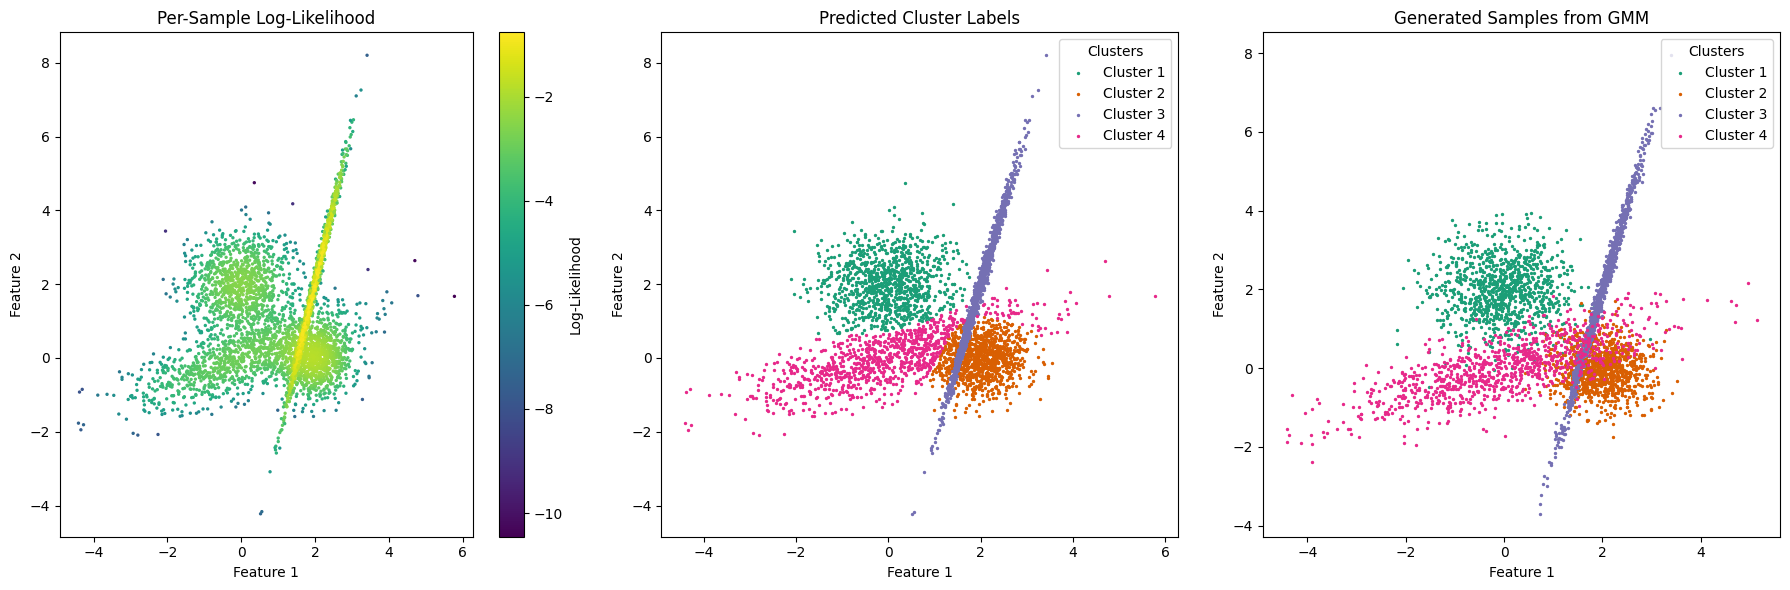

In [11]:
colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
color_map = {label: color for label, color in enumerate(colors)}

# Create 1x3 plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Log-Likelihood of Each Sample
scatter = axs[0].scatter(X[:, 0], X[:, 1], c=log_probs.detach().cpu().numpy(), cmap='viridis', s=2)
axs[0].set_title('Per-Sample Log-Likelihood')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Log-Likelihood')

# Plot 2: Predicted Cluster Labels
for cluster in range(n_components):
    cluster_points = X[y_pred.detach().cpu().numpy() == cluster]
    axs[1].scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   label=f'Cluster {cluster + 1}', 
                   color=color_map[cluster], 
                   s=2)
axs[1].set_title('Predicted Cluster Labels')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')
axs[1].legend(title="Clusters", loc='upper right')

# Plot 3: Generated Samples with consistent colors
for cluster in range(n_components):
    cluster_samples = gmm_samples[gmm_labels == cluster]
    axs[2].scatter(cluster_samples[:, 0], cluster_samples[:, 1], 
                   label=f'Cluster {cluster + 1}', 
                   color=color_map[cluster], 
                   s=2)
axs[2].set_title('Generated Samples from GMM')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
axs[2].legend(title="Clusters", loc='upper right')

plt.tight_layout()
plt.savefig('figures/gmm_methods.pdf', format='pdf', dpi = 400)
plt.show()


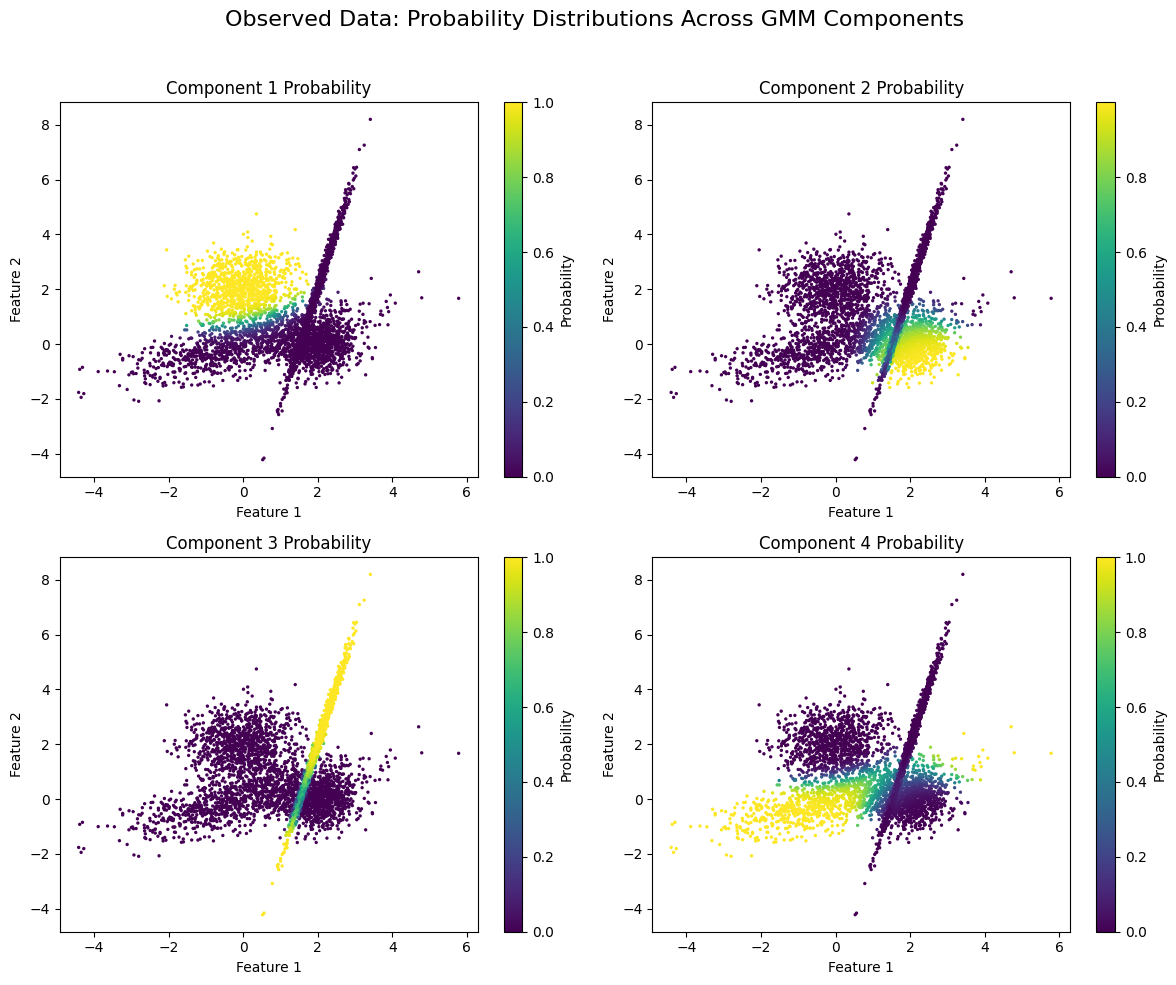

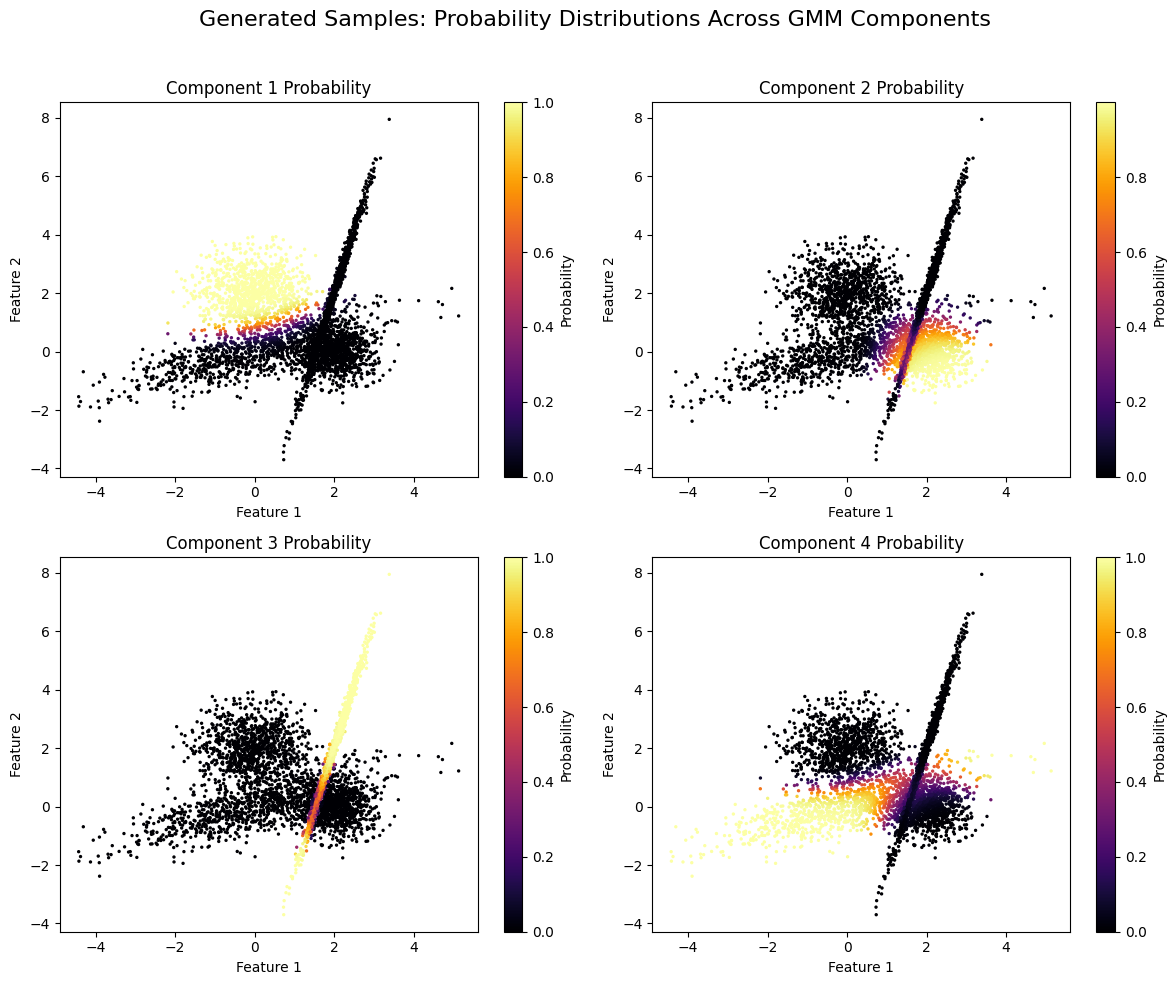

In [12]:
# Observed Data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = probs[:, k]
    scatter = ax.scatter(X[:, 0], X[:, 1], c=prob_k.detach().cpu().numpy(), cmap='viridis', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Observed Data: Probability Distributions Across GMM Components", fontsize=16)
plt.savefig('figures/gmm_probs_observed.pdf', format='pdf', dpi = 400)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Generated Samples
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for k, ax in enumerate(axs.ravel()):
    prob_k = generated_probs[:, k]
    scatter = ax.scatter(gmm_samples[:, 0], gmm_samples[:, 1], c=prob_k, cmap='inferno', s=2)
    ax.set_title(f'Component {k+1} Probability')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Probability')

fig.suptitle("Generated Samples: Probability Distributions Across GMM Components", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/gmm_probs_samples.pdf', format='pdf', dpi = 400)
plt.show()


In [13]:
def plot_gmm(gmm, X, labels_pred, initial_means=None, initial_covariances=None, ax=None, title='Gaussian Mixture'):
    if ax is None:
        ax = plt.gca()
    
    cmap = ListedColormap(plt.cm.winter(np.linspace(0, 1, gmm.n_components)))    
    
    for i, color in zip(range(gmm.n_components), cmap.colors):
        mask = labels_pred == i
        ax.scatter(X[mask, 0], X[mask, 1], c=[color], s=1, zorder=2)

    # Plot ellipses and means
    for n, color in zip(range(gmm.n_components), cmap.colors):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        # Determine covariance based on type
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()

        # Calculate ellipse parameters
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        # Plot ellipses for standard deviations
        for std_dev, alpha in zip([1, 2, 3], [0.6, 0.4, 0.2]):
            width, height = 2 * np.sqrt(vals) * std_dev
            ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=None, facecolor=color, alpha=alpha, zorder=1)
            ax.add_patch(ellipse)

        # Plot mean as a dot
        ax.plot(mean[0], mean[1], 'ko', markersize=3, zorder=4)

    if initial_means is not None:
        for n in range(gmm.n_components):
            initial_mean = initial_means[n].detach().cpu().numpy()
            ax.plot(initial_mean[0], initial_mean[1], 'r+', markersize=20, zorder=4)
            if initial_covariances is not None:
                initial_cov = initial_covariances[n].detach().cpu().numpy()
                vals, vecs = np.linalg.eigh(initial_cov)
                order = vals.argsort()[::-1]
                vals, vecs = vals[order], vecs[:, order]
                theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

                width, height = 2 * np.sqrt(vals)
                ellipse = Ellipse(xy=initial_mean, width=width, height=height, angle=theta, edgecolor='red', linestyle='--', facecolor='none', zorder=1)
                ax.add_patch(ellipse)

    ax.set_title(title)
    ax.axis('equal')

Iteration 0, lower bound: -6.640768527984619
Iteration 1, lower bound: -4.270711898803711
Iteration 2, lower bound: -4.148900508880615
Iteration 3, lower bound: -4.050899982452393
Iteration 4, lower bound: -4.018013954162598
Iteration 5, lower bound: -4.008553981781006
Iteration 6, lower bound: -4.004339218139648
Iteration 7, lower bound: -4.001521110534668
Iteration 8, lower bound: -3.9994118213653564
Iteration 9, lower bound: -3.997814893722534
Iteration 10, lower bound: -3.9966182708740234
Iteration 11, lower bound: -3.995734691619873
Iteration 12, lower bound: -3.9950900077819824
Iteration 13, lower bound: -3.9946248531341553
Converged at iteration 14 with lower bound -3.994291305541992
Iteration 0, lower bound: -6.640768527984619
Iteration 1, lower bound: -4.218067646026611
Iteration 2, lower bound: -4.0062150955200195
Iteration 3, lower bound: -3.8300743103027344
Iteration 4, lower bound: -3.7850418090820312
Iteration 5, lower bound: -3.7730305194854736
Iteration 6, lower bound: 

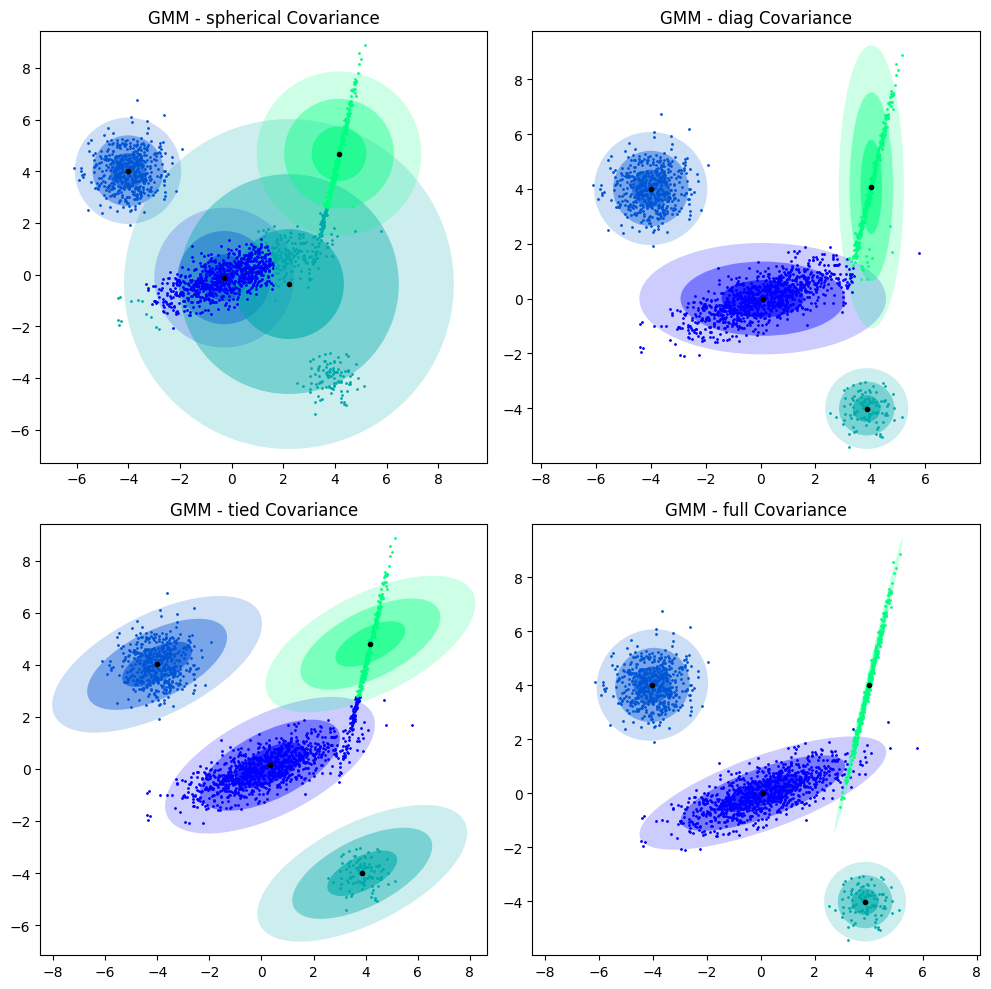

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

init_params = 'random'
n_features = 2
n_components = 4
random_state = 42
max_iter = 1000
np.random.seed(random_state)
torch.manual_seed(random_state)

n_samples_1 = 1000
n_samples_2 = 500
n_samples_3 = 100
n_samples_4 = 300
center_1 = np.array([0, 0])
center_2 = np.array([-4, 4])
center_3 = np.array([4, -4])
center_4 = np.array([4, 4])
C = np.array([[0.0, -0.5], [1.5, 0.5]])
C_2 = np.array([[0.0, 0.2], [0.4, 1.7]])
component_1 = np.dot(np.random.randn(n_samples_1, 2), C) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 2) + center_2
component_3 = .5 * np.random.randn(n_samples_3, 2) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 2), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4])

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
covariance_types = ['spherical', 'diag', 'tied', 'full']

for ax, cov_type in zip(axs.ravel(), covariance_types):
    gmm = GaussianMixture(n_features=n_features, 
                          n_components=n_components, 
                          covariance_type=cov_type, 
                          max_iter=max_iter, 
                          init_params=init_params, 
                          random_state=random_state, 
                          device=device, 
                          verbose=True, 
                          verbose_interval=1)
    gmm.fit(X_tensor)
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X_tensor, y_pred, ax=ax, title=f'GMM - {cov_type} Covariance')

plt.tight_layout()
#plt.savefig('figures/covariance_types.pdf', dpi = 400)
plt.show()

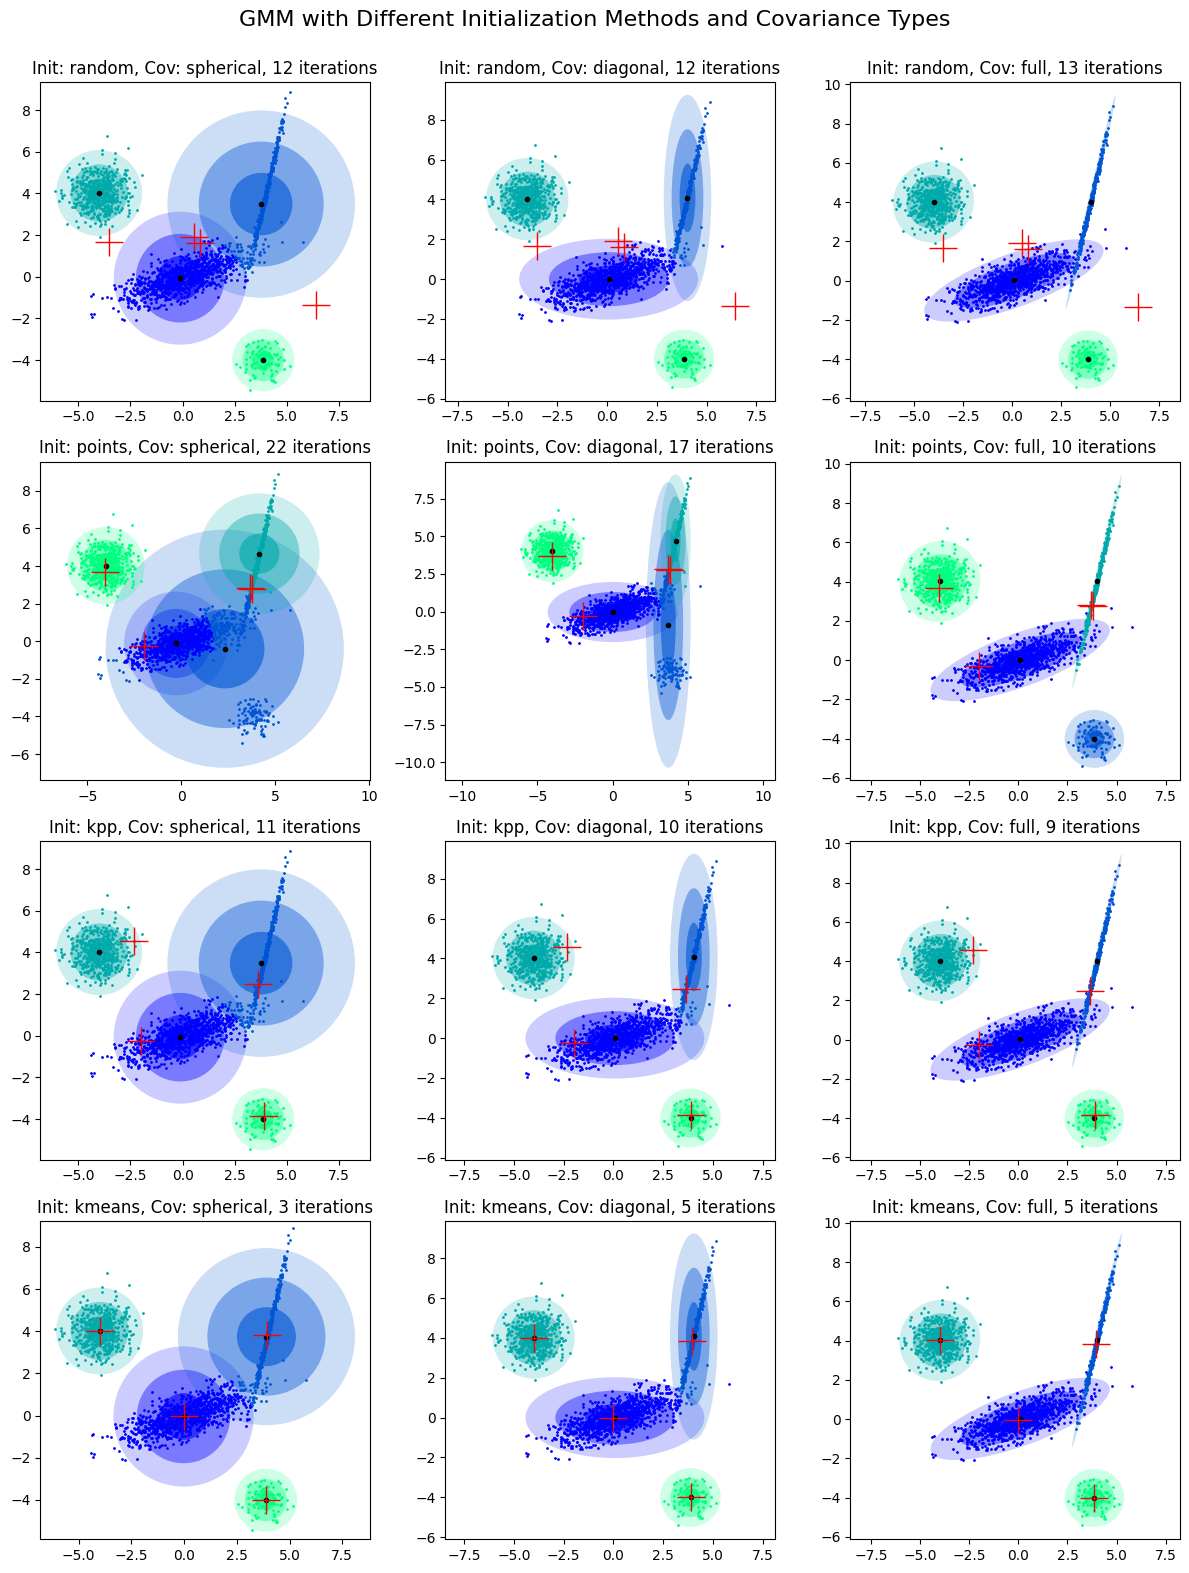

In [15]:
# Prepare the 4 by 3 plot for five initialization methods
fig, axs = plt.subplots(4, 3, figsize=(12, 16))
init_methods = ['random', 'points', 'kpp', 'kmeans']
titles = ['Init: random', 'Init: points', 'Init: kpp', 'Init: kmeans']

# Loop through and plot each initialization method with different covariance types
for i, (init_method, title) in enumerate(zip(init_methods, titles)):
    # Spherical covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='spherical', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_points(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_random(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, ax=axs[i, 0], title=f'{title}, Cov: spherical, {n_iter} iterations')

    # Diagonal covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='diag', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    gmm.means_init = initial_mean  # Use the same initial means
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=axs[i, 1], title=f'{title}, Cov: diagonal, {n_iter} iterations')

    # Full covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    gmm.means_init = initial_mean # Use the same initial means
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=axs[i, 2], title=f'{title}, Cov: full, {n_iter} iterations')

# Adjust layout and move the main title to avoid covering the subtitles
plt.suptitle('GMM with Different Initialization Methods and Covariance Types', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
#plt.savefig('figures/initialization_methods.pdf', dpi = 400)
plt.show()


## Experimental: Max Dist Method

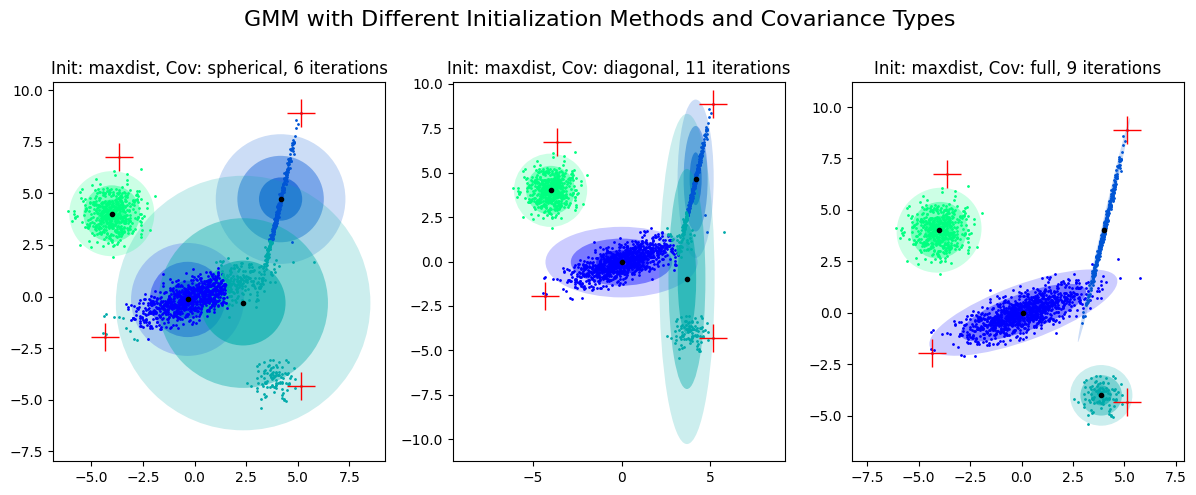

In [16]:
# Prepare the 4 by 3 plot for five initialization methods
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
init_methods = ['maxdist']
titles = ['Init: maxdist']

# Loop through and plot each initialization method with different covariance types
for i, (init_method, title) in enumerate(zip(init_methods, titles)):
    # Spherical covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='spherical', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    if init_method == 'points':
        gmm.means_init = gmm._init_kpoints(X_tensor, n_components)
    elif init_method == 'kpp':
        gmm.means_init = gmm._init_kpp(X_tensor, n_components)
    elif init_method == 'random':
        gmm.means_init = gmm._init_krandom(X_tensor, n_components)
    elif init_method == 'maxdist':
        gmm.means_init = gmm._init_maxdist(X_tensor, n_components)
    elif init_method == 'kmeans':
        gmm.means_init = gmm._init_kmeans(X_tensor, n_components)
    initial_mean = gmm.means_init
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, ax=axs[0], title=f'{title}, Cov: spherical, {n_iter} iterations')

    # Diagonal covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='diag', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    gmm.means_init = initial_mean  # Use the same initial means
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=axs[1], title=f'{title}, Cov: diagonal, {n_iter} iterations')

    # Full covariance
    gmm = GaussianMixture(n_features=n_features, n_components=n_components, covariance_type='full', max_iter=max_iter, init_params=init_method, random_state=random_state, device=device)
    gmm.means_init = initial_mean # Use the same initial means
    gmm.fit(X_tensor)
    n_iter = gmm.n_iter_
    y_pred = gmm.predict(X_tensor).cpu().numpy()
    plot_gmm(gmm, X, y_pred, initial_means=initial_mean, initial_covariances=None, ax=axs[2], title=f'{title}, Cov: full, {n_iter} iterations')

# Adjust layout and move the main title to avoid covering the subtitles
plt.suptitle('GMM with Different Initialization Methods and Covariance Types', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
#plt.savefig('figures/initialization_methods.pdf', dpi = 400)
plt.show()
